<a href="https://colab.research.google.com/github/devncasagrande/PjTransferLearningCatandDog/blob/main/PjTransferLearning1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Importar bibliotecas

In [ ]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras
import os


import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.utils import to_categorical


# Nova seção2 – Upload do dataset (pasta ZIP com cats e dogs)

In [ ]:
from google.colab import files
import zipfile

# Upload do arquivo dataset.zip
uploaded = files.upload()

# Extrair o zip
for fn in uploaded.keys():
    with zipfile.ZipFile(fn, 'r') as zip_ref:
        zip_ref.extractall(".")


Saving dataset_CatandDog.zip to dataset_CatandDog.zip


# 3 Preparar dataset manual

In [ ]:
# Estrutura esperada:
# dataset_CatandDog/
#    imgs/
#       Cat/
#       Dog/

root = "dataset_CatandDog/imgs"
categories = ["Cat", "Dog"]


def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

data = []
for c, category in enumerate(categories):
    folder = os.path.join(root, category)
    images = [os.path.join(folder, f) for f in os.listdir(folder)
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        try:
            img, x = get_image(img_path)
            data.append({'x': np.array(x[0]), 'y': c})
        except:
            pass  # ignora imagens ruins

# Embaralhar e dividir em treino/val/test
random.shuffle(data)
train_split, val_split = 0.7, 0.15
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))

train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

# Normalizar e converter labels em one-hot
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

num_classes = len(categories)
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

print("Train:", x_train.shape, y_train.shape)
print("Val:", x_val.shape, y_val.shape)
print("Test:", x_test.shape, y_test.shape)


Train: (786, 224, 224, 3) (786, 2)
Val: (168, 224, 224, 3) (168, 2)
Test: (169, 224, 224, 3) (169, 2)


# 4 Configurar Transfer Learning (MobileNetV2)

In [ ]:
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Congelar camadas base inicialmente
for layer in base_model.layers:
    layer.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# 5 Compilar e treinar (fase 1)

In [ ]:
from keras.optimizers import Adam

#copilar modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=32
)


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.6262 - loss: 0.6363 - val_accuracy: 0.8214 - val_loss: 0.4467
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.7789 - loss: 0.4840 - val_accuracy: 0.8750 - val_loss: 0.3473
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8347 - loss: 0.3844 - val_accuracy: 0.8929 - val_loss: 0.2945
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8574 - loss: 0.3446 - val_accuracy: 0.9107 - val_loss: 0.2568
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9107 - loss: 0.2522 - val_accuracy: 0.9226 - val_loss: 0.2261


# 6 Fine-tuning (descongelar últimas camadas)

In [ ]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

history_ft = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=32
)


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.7188 - loss: 0.6269 - val_accuracy: 0.9345 - val_loss: 0.1611
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8470 - loss: 0.3503 - val_accuracy: 0.9524 - val_loss: 0.1280
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9044 - loss: 0.2328 - val_accuracy: 0.9643 - val_loss: 0.1106
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9020 - loss: 0.2201 - val_accuracy: 0.9643 - val_loss: 0.1022
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9320 - loss: 0.1961 - val_accuracy: 0.9583 - val_loss: 0.0957


# 7 Avaliar e salvar modelo

In [ ]:
loss, acc = model.evaluate(x_test, y_test)
print("Test accuracy:", acc)

model.save("cats_vs_dogs_transfer_manual.h5")


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9696 - loss: 0.0827


Test accuracy: 0.976331353187561


# 8 Testar modelo

In [ ]:
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.0
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    print("Previsão:", categories[class_idx], "| Confiança:", preds[0][class_idx])

# Upload e testar imagem
uploaded = files.upload()
for fn in uploaded.keys():
    predict_image(fn)


Saving pexels-kmerriman-20787.jpg to pexels-kmerriman-20787.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Previsão: Cat | Confiança: 0.990343


# 9 Visualizar imagens do dataset

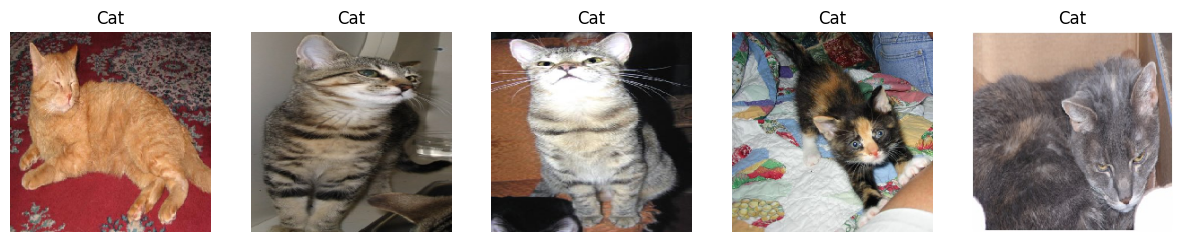

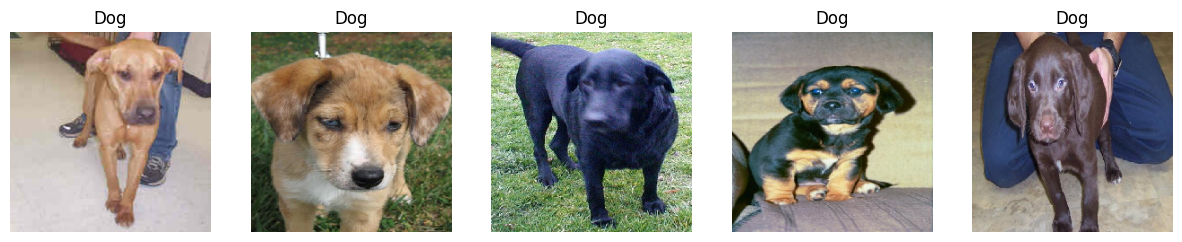

In [ ]:
import matplotlib.pyplot as plt
import random
from IPython.display import display

# Mostrar algumas imagens aleatórias de cada categoria
num_examples = 5  # quantas imagens de cada categoria mostrar

for category in categories:
    folder = os.path.join(root, category)
    images = [os.path.join(folder, f) for f in os.listdir(folder)
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    sample = random.sample(images, min(num_examples, len(images)))

    plt.figure(figsize=(15,3))
    for i, img_path in enumerate(sample):
        img = image.load_img(img_path, target_size=(224,224))
        plt.subplot(1, num_examples, i+1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.show()


Impressão de resumo

In [ ]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 1123 images from 2 categories
train / validation / test split: 786, 168, 169
training data shape:  (786, 224, 224, 3)
training labels shape:  (786, 2)


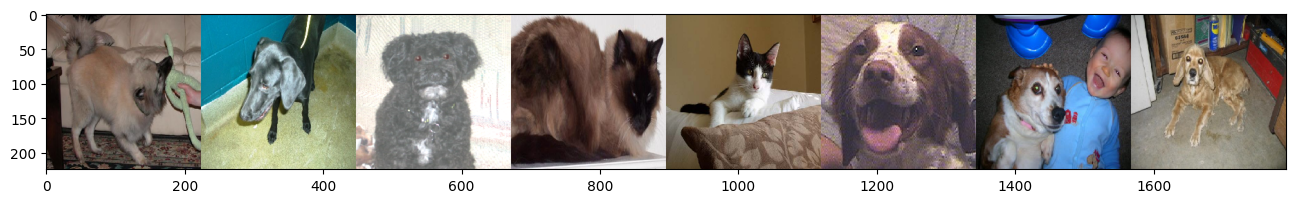

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)